In [92]:
library(dplyr)
library(tidyr)
library(readr)
library(purrr)
library(here)
library(lubridate)
library(ggplot2)
library(sicegar)
library(scales)



Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




Data Import and Preparation

In [ ]:
pollen_daily <- read_delim(paste0(here(), "/data/dwh/pollen_dwh_daily.txt"), delim = " ", skip = 17, trim_ws = TRUE)
pollen_daily %<>% 
    mutate(across(is.numeric, ~ if_else(. < 0, NA_real_, .)),
    # datetime = ymd_hm(paste0(YYYY, "-", sprintf("%02d", MM), "-", sprintf("%02d", DD), " ", sprintf("%02d", HH), ":", sprintf("%02d", mm))),
    monthday = paste0(sprintf("%02d", MM), sprintf("%02d", DD))) %>%
    select(-(YYYY:mm)) %>%
    setNames(tolower(names(.))) %>%
    pivot_longer(plo:pcf, names_to = "station", values_to = "conc") %>%
    group_by(parameter, station, monthday) %>%
    summarise(conc = mean(conc, na.rm = TRUE)) %>%
    ungroup() %>%
    filter(monthday != "0229") %>%
    split(.$parameter)
pollen_daily




In [106]:
pollen_daily_sum <- map(pollen_daily, ~.x %>%
    group_by(parameter, monthday) %>%
    summarise(conc = sum(conc, na.rm = TRUE)) %>%
    ungroup() %>%
    mutate(time = 1:365,
    intensity = rescale(conc)) %>%
    select(time, intensity))
pollen_daily_sum

`summarise()` has grouped output by 'parameter'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'parameter'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'parameter'. You can override using the `.groups` argument.



time,intensity
<int>,<dbl>
1,0.005629877
2,0.008036046
3,0.009568933
4,0.004180602
5,0.050538833
6,0.006596061
7,0.018394649
8,0.028985507
9,0.030146786


Timeseries Plots

Warning message:
“Removed 1260 rows containing missing values (position_stack).”
Warning message:
“Removed 1260 rows containing missing values (position_stack).”


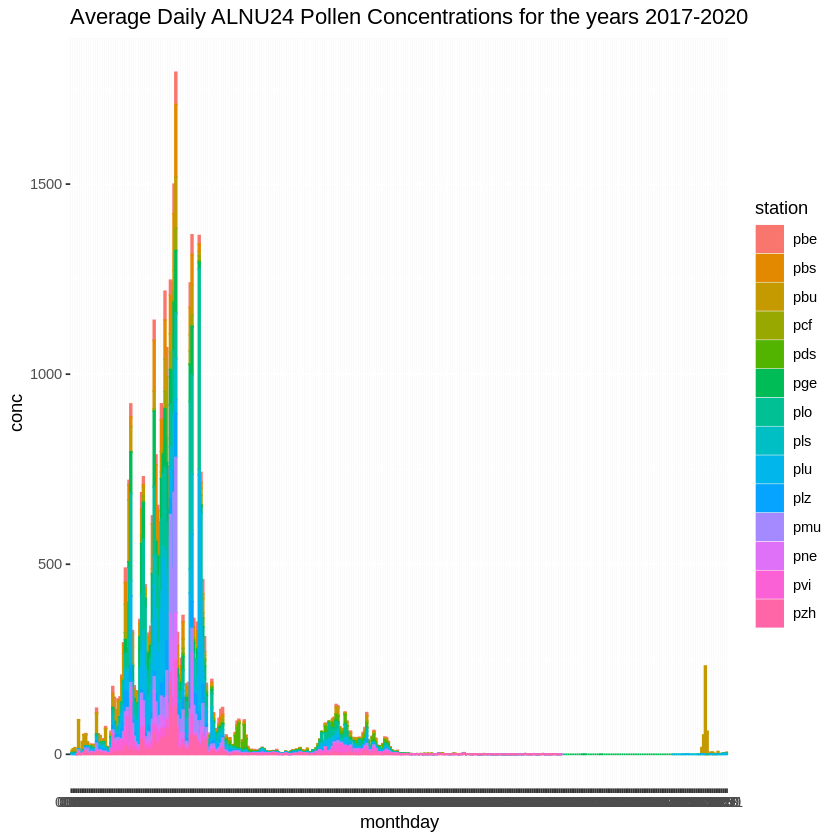

Warning message:
“Removed 1260 rows containing missing values (position_stack).”


$ALNU24

$BETU24

$POAC24


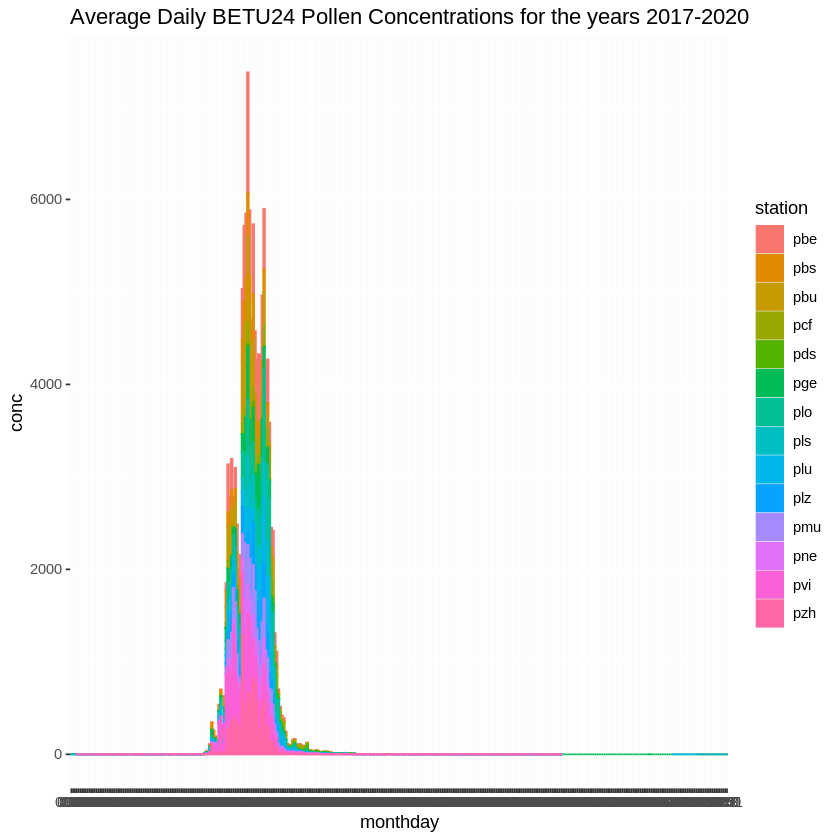

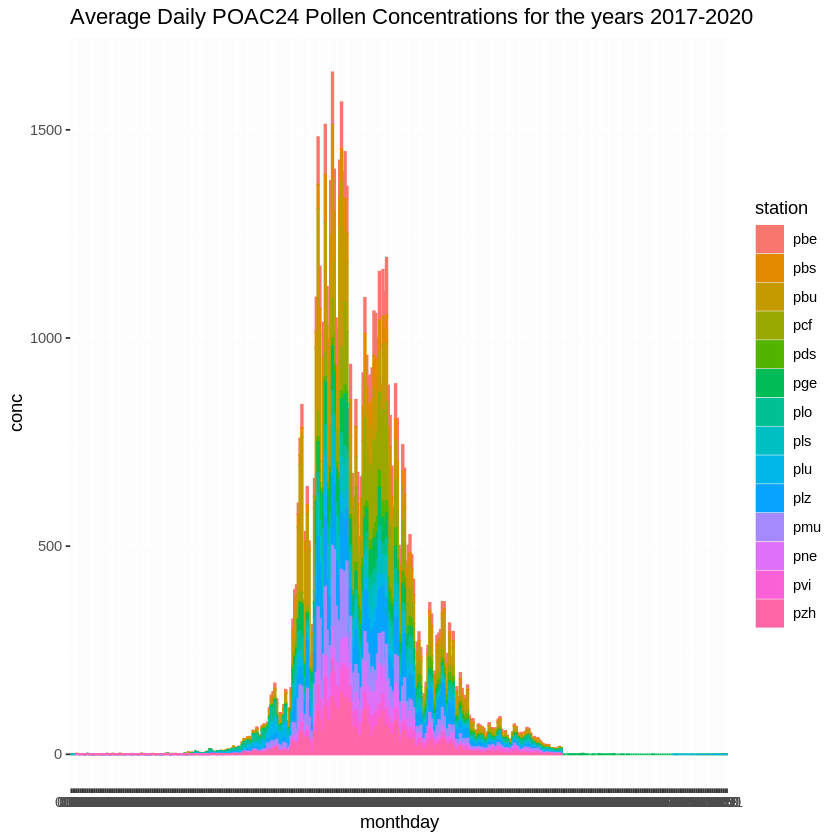

In [94]:
map(pollen_daily, ~
    ggplot(.x, aes(x = monthday, y = conc, col = station, fill = station)) +
    geom_col() +
    ggtitle(paste("Average Daily", unique(.x$parameter), "Pollen Concentrations for the years 2017-2020")))

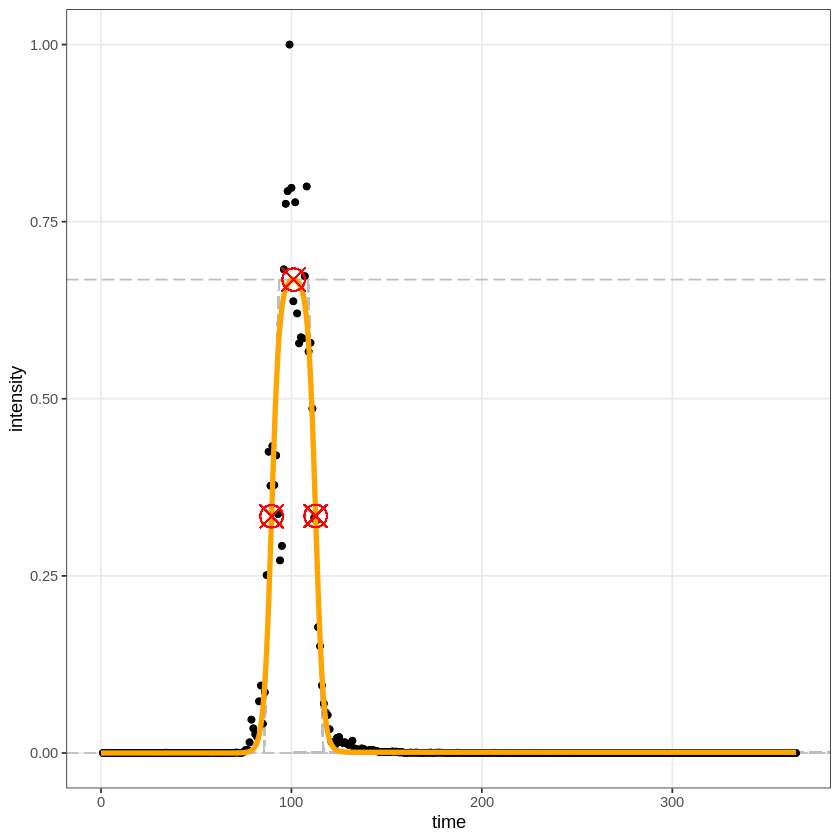

In [115]:
normalizedInput <- normalizeData(dataInput = pollen_daily_sum[[2]], 
                                                dataInputName = "doubleSigmoidalSample")
# Fit double-sigmoidal model
doubleSigmoidalModel <- multipleFitFunction(dataInput = normalizedInput,
                                                model = "doublesigmoidal",
                                                n_runs_min = 20,
                                                n_runs_max = 500,
                                                showDetails = FALSE)                                                
# Calculate additional parameters
doubleSigmoidalModel <- parameterCalculation(doubleSigmoidalModel)

# Plotting the model
figureModelCurves(dataInput = normalizedInput,
doubleSigmoidalFitVector = doubleSigmoidalModel,
showParameterRelatedLines = TRUE)

In [112]:
parameterCalculation(doubleSigmoidalModel)

finalAsymptoteIntensityRatio_N_Estimate,finalAsymptoteIntensityRatio_Std_Error,finalAsymptoteIntensityRatio_t_value,finalAsymptoteIntensityRatio_Pr_t,maximum_N_Estimate,maximum_Std_Error,maximum_t_value,maximum_Pr_t,slope1Param_N_Estimate,slope1Param_Std_Error,⋯,incrementTime,startPoint_x,startPoint_y,reachMaximum_x,reachMaximum_y,decrementTime,startDeclinePoint_x,startDeclinePoint_y,endDeclinePoint_x,endDeclinePoint_y
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.0126032,0.009910278,1.271731,0.2042921,0.5034638,0.02446694,20.57731,1.053957e-62,37.62583,10.70903,⋯,27.74844,24.453,0,52.20144,0.5034638,23.0163,59.21159,0.5034638,82.22789,0.006345256
